There have been many discussions about links between samples in the train and test data, because the robot's absolute orientation does not change much in one run. This means that a) it is dangerously easy to create a model which looks like it predicts surfaces when in fact it predicts orientation and b) we might gain some additional knowledge about the data.

Let's settle this once and for all.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First, let's get our raw data:

In [4]:
train_X = pd.read_csv('../input/X_train.csv').iloc[:,3:].values.reshape(-1,128,10)
test_X  = pd.read_csv('../input/X_test.csv' ).iloc[:,3:].values.reshape(-1,128,10)
print('train_X shape:', train_X.shape, ', test_X shape:', test_X.shape)

train_X shape: (3810, 128, 10) . test_X shape: (3816, 128, 10)


...and y / group data:

In [8]:
df_train_y = pd.read_csv('../input/y_train.csv')

# build a dict to convert surface names into numbers
surface_names = df_train_y['surface'].unique()
num_surfaces = len(surface_names)
surface_to_numeric = dict(zip(surface_names, range(num_surfaces)))
print('Convert to numbers: ', surface_to_numeric)

# y and group data as numeric values:
train_y = df_train_y['surface'].replace(surface_to_numeric).values
train_group = df_train_y['group_id'].values

Convert to numbers:  {'fine_concrete': 0, 'concrete': 1, 'soft_tiles': 2, 'tiled': 3, 'soft_pvc': 4, 'hard_tiles_large_space': 5, 'carpet': 6, 'hard_tiles': 7, 'wood': 8}


Let's plot the 4 orientation channels of a random group in series:

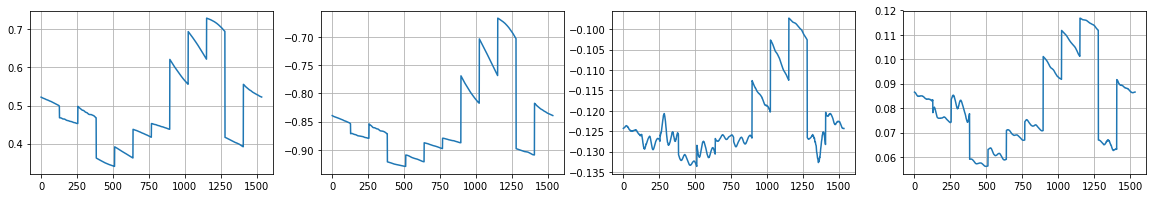

In [15]:
fig, axes = plt.subplots(1,4)
fig.set_size_inches(20,3)

for i in range(4):
    axes[i].plot(train_X[train_group == 17][:,:,i].reshape(-1))
    axes[i].grid(True)

Well, that certainly looks like a jigsaw puzzle to me. And that leads to an idea: the euclidean distance in the 4-dimensional "orientation space" between, for example, the right edge of one sample and the left edge of its true neighbor should be a minimum, *ideally even among all samples*, not only the samples in its group. Same for left/right. This should enable us to stitch the runs together again. All we have to do is link samples together which are *each other's* closest neighbors. Let's code:

In [18]:
def sq_dist(a,b):
    ''' the squared euclidean distance between two samples '''
    
    return np.sum((a-b)**2, axis=1)


def find_run_edges(data, edge):
    ''' examine links between samples. left/right run edges are those samples which do not have a link on that side. '''

    if edge == 'left':
        border1 = 0
        border2 = -1
    elif edge == 'right':
        border1 = -1
        border2 = 0
    else:
        return False
    
    edge_list = []
    linked_list = []
    
    for i in range(len(data)):
        dist_list = sq_dist(data[i, border1, :4], data[:, border2, :4]) # distances to rest of samples
        min_dist = np.min(dist_list)
        closest_i   = np.argmin(dist_list) # this is i's closest neighbor
        if closest_i == i: # this might happen and it's definitely wrong
            print('Sample', i, 'linked with itself. Next closest sample used instead.')
            closest_i = np.argsort(dist_list)[1]
        dist_list = sq_dist(data[closest_i, border2, :4], data[:, border1, :4]) # now find closest_i's closest neighbor
        rev_dist = np.min(dist_list)
        closest_rev = np.argmin(dist_list) # here it is
        if closest_rev == closest_i: # again a check
            print('Sample', i, '(back-)linked with itself. Next closest sample used instead.')
            closest_rev = np.argsort(dist_list)[1]
        if (i != closest_rev): # we found an edge
            edge_list.append(i)
        else:
            linked_list.append([i, closest_i, min_dist])
            
    return edge_list, linked_list


def find_runs(data, left_edges, right_edges):
    ''' go through the list of samples & link the closest neighbors into a single run '''
    
    data_runs = []

    for start_point in left_edges:
        i = start_point
        run_list = [i]
        while i not in right_edges:
            tmp = np.argmin(sq_dist(data[i, -1, :4], data[:, 0, :4]))
            if tmp == i: # self-linked sample
                tmp = np.argsort(sq_dist(data[i, -1, :4], data[:, 0, :4]))[1]
            i = tmp
            run_list.append(i)
        data_runs.append(np.array(run_list))
    
    return data_runs

Let's go:

In [19]:
train_left_edges, train_left_linked  = find_run_edges(train_X, edge='left')
train_right_edges, train_right_linked = find_run_edges(train_X, edge='right')
print('Found', len(train_left_edges), 'left edges and', len(train_right_edges), 'right edges.')

Sample 1 (back-)linked with itself. Next closest sample used instead.
Sample 216 linked with itself. Next closest sample used instead.
Sample 335 linked with itself. Next closest sample used instead.
Sample 748 (back-)linked with itself. Next closest sample used instead.
Sample 799 linked with itself. Next closest sample used instead.
Sample 1205 linked with itself. Next closest sample used instead.
Sample 1913 linked with itself. Next closest sample used instead.
Sample 1986 linked with itself. Next closest sample used instead.
Sample 2555 linked with itself. Next closest sample used instead.
Sample 2612 linked with itself. Next closest sample used instead.
Sample 2761 linked with itself. Next closest sample used instead.
Sample 2917 linked with itself. Next closest sample used instead.
Sample 3312 linked with itself. Next closest sample used instead.
Sample 181 linked with itself. Next closest sample used instead.
Sample 272 linked with itself. Next closest sample used instead.
Sampl

Well, that certainly looks promising. Found 76 runs, similar number than the number of groups. Build the runs:

In [21]:
train_runs = find_runs(train_X, train_left_edges, train_right_edges)

Have we found all samples? Have we used any sample twice? The answer is yes, and no. Perfect.

In [23]:
flat_list = [series_id for run in train_runs for series_id in run]
print(len(flat_list), len(np.unique(flat_list)))

3810 3810


Now for the real test. How many different surfaces are in each run? *Only 4 runs have more than one surface* (and if you look at them, you can easily split them by hand). This actually works!

In [26]:
print([ len(np.unique(train_y[run])) for run in train_runs ])

[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]


Interesting. Some runs contain  2, 3 and even 4 groups. So several groups were cut from one run:

In [27]:
print([ len(np.unique(train_group[run])) for run in train_runs ])

[2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 4, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1]


Let's plot all 10 channels for one run.  Beautiful.

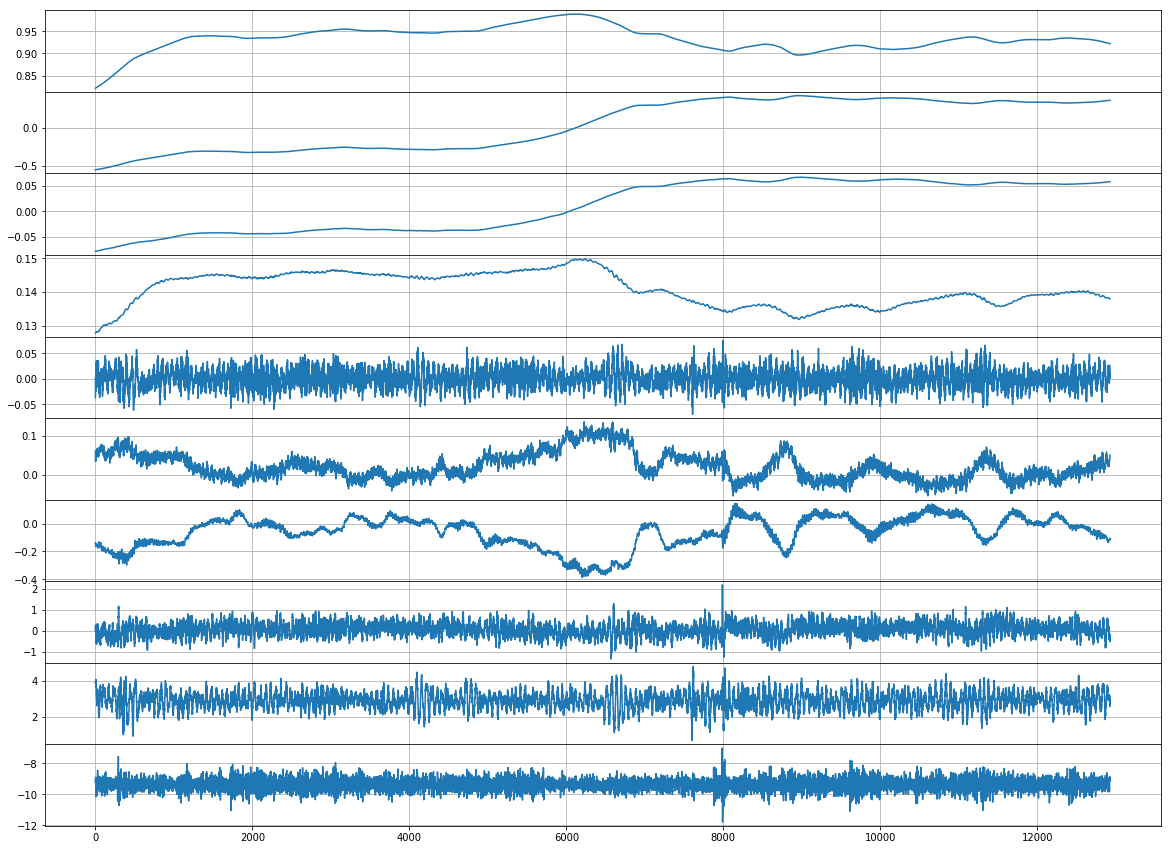

In [33]:
fig, axes = plt.subplots(10,1, sharex=True)
fig.set_size_inches(20,15)
fig.subplots_adjust(hspace=0)

for i in range(10):
    axes[i].plot(train_X[train_runs[0]][:,:,i].reshape(-1))
    axes[i].grid(True)

Let's add our new knowledge to train_y. Now you can use this info to train your models to even greater perfection. Enjoy!

In [47]:
df_train_y['run_id'] = 0
df_train_y['run_pos'] = 0

for run_id in range(len(train_runs)):
    for run_pos in range(len(train_runs[run_id])):
        series_id = train_runs[run_id][run_pos]
        df_train_y.at[ series_id, 'run_id'  ] = run_id
        df_train_y.at[ series_id, 'run_pos' ] = run_pos

df_train_y.to_csv('y_train_with_runs.csv', index=False)
df_train_y.tail()

,series_id,group_id,surface,run_id,run_pos
3805,3805,55,tiled,46,4
3806,3806,67,wood,74,2
3807,3807,48,fine_concrete,65,57
3808,3808,54,tiled,54,97
3809,3809,56,soft_pvc,69,123


...But wait. Might this also work with the test data?

In [48]:
test_left_edges, test_left_linked  = find_run_edges(test_X, edge='left')
test_right_edges, test_right_linked = find_run_edges(test_X, edge='right')
print('Found', len(test_left_edges), 'left edges and', len(test_right_edges), 'right edges.')

Sample 355 linked with itself. Next closest sample used instead.
Sample 580 linked with itself. Next closest sample used instead.
Sample 1402 linked with itself. Next closest sample used instead.
Sample 1547 linked with itself. Next closest sample used instead.
Sample 1716 linked with itself. Next closest sample used instead.
Sample 2136 (back-)linked with itself. Next closest sample used instead.
Sample 2474 linked with itself. Next closest sample used instead.
Sample 2495 (back-)linked with itself. Next closest sample used instead.
Sample 2600 linked with itself. Next closest sample used instead.
Sample 2922 linked with itself. Next closest sample used instead.
Sample 580 linked with itself. Next closest sample used instead.
Sample 1216 linked with itself. Next closest sample used instead.
Sample 1409 linked with itself. Next closest sample used instead.
Sample 1410 linked with itself. Next closest sample used instead.
Sample 1670 linked with itself. Next closest sample used instead.

Oh yeah!

In [49]:
test_runs = find_runs(test_X, test_left_edges, test_right_edges)

Again no samples are used twice, but we have lost some.

In [50]:
flat_list = [series_id for run in test_runs for series_id in run]
print(len(flat_list), len(np.unique(flat_list)))

3790 3790


 3816 - 3790 = 26 samples are not in any run and aren't edges. They must form a closed ring -> another run. find it:

In [52]:
lost_samples = np.array([ i for i in range(len(test_X)) if i not in np.concatenate(test_runs) ])
print(lost_samples)
print(len(lost_samples))

[ 264  361  529  620  733  954 1148 1248 1432 1534 1570 1738 1739 2090
 2205 2714 2847 2978 2991 3115 3173 3183 3195 3359 3517 3655]
26


In [55]:
find_run_edges(test_X[lost_samples], edge='left')[1][0]

[0, 5, 2.0548399999999954e-07]

In [57]:
lost_run = np.array(lost_samples[find_runs(test_X[lost_samples], [0], [5])[0]])
test_runs.append(lost_run)

Perfect. Now we also have test runs. A nice plot to prove it:

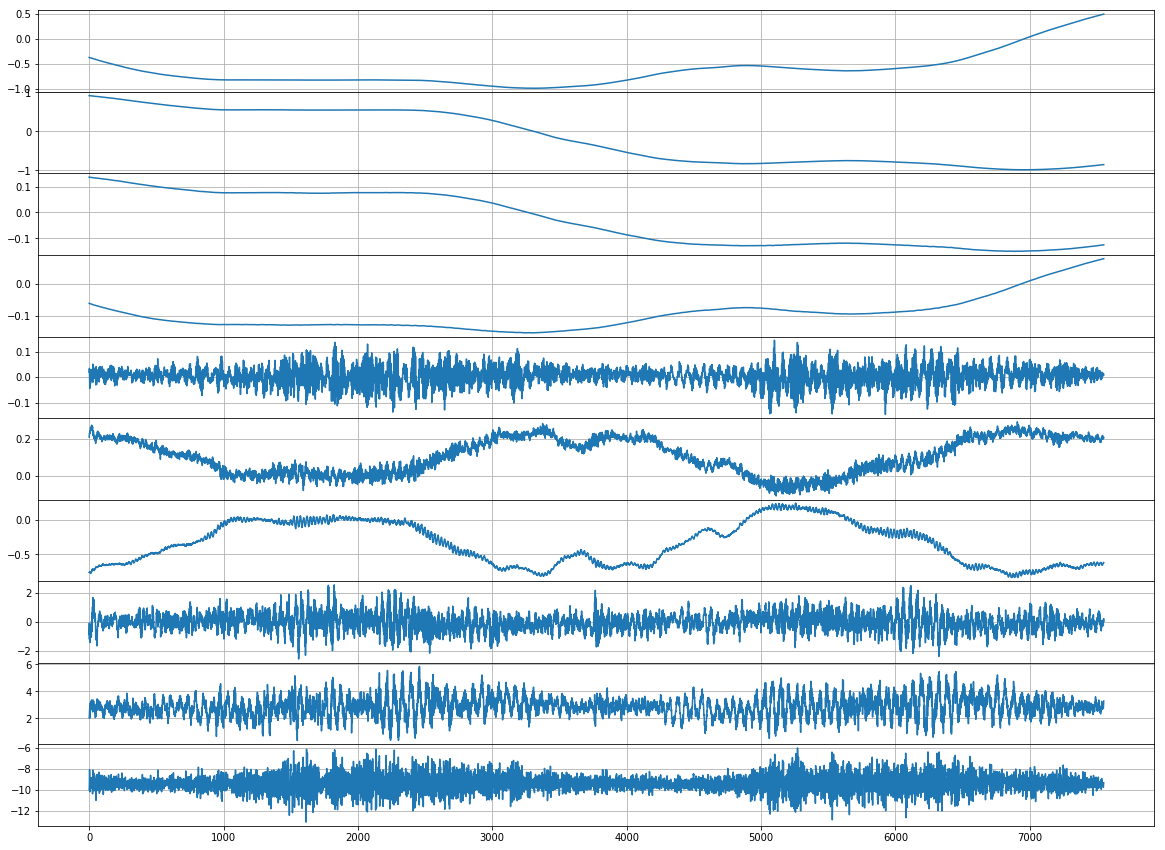

In [61]:
fig, axes = plt.subplots(10,1, sharex=True)
fig.set_size_inches(20,15)
fig.subplots_adjust(hspace=0)

for i in range(10):
    axes[i].plot(test_X[test_runs[1]][:,:,i].reshape(-1))
    axes[i].grid(True)

I'll leave you with a caution and an exercise:
First, there are certainly some errors in the test runs. Two runs with different surfaces might have been stitched into one (as happened 4 times with the train data) by chance.
Second, might it even be possible to link *across train and test*? Well, see for yourself...